# Exploratory Data Analysis

In this notebook, we'll explore the relationships (if they exist) amongst the Zika virus data and the precipitation data across Argentina.

## Import libraries

We'll begin by importing all the necessary libraries. This includes `pandas` to work with csv files and data frames, `matplotlib` to draw plots and `geopandas` to work with geographical data. We'll also import necessary additional libraries (`descartes` and `Point`) to make everything work together.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import descartes
import geopandas as gpd
from shapely.geometry import Point

## Load datasets

We'll load in the data for coordinates for various provinces in Argentina via a file `places.csv`. Then, we'll import the Zika and precipitation monthly files.

In [2]:
# Location information
places = pd.read_csv("zika_data/places.csv")

# April, 2016 Zika data
zika_data = pd.read_csv("zika_data/2016-04.csv")
# April, 2016 Precipitation information
precipitation_data = pd.read_csv("data/precipitation_4_2016.csv")

## Universal functions

Here, we define a set of functions that can be used for any month and handle both the Zika and the precipitation datasets.

### Function: get_zika_coordinates

This function returns the list of all provinces of Argentina, with their coordinates and the number of Zika cases for that given month.

In [3]:
def get_zika_coordinates(data, places):
    """
    The function combines the Zika data with coordinates of 
    its respective province and then returns the aggregated 
    data for each province.
    """
    
    data_updated = pd.merge(data, 
                            places, 
                            how = 'inner', 
                            left_on = "location", 
                            right_on = "location")
    
    data_updated = data_updated[["location", "value", "latitude", "longitude"]] \
                                .groupby(["location", "latitude", "longitude"]) \
                                .sum().reset_index()

    data_updated["location"] = data_updated["location"] \
                                            .apply(lambda x: x.split("-")[1] \
                                                   .replace("_", " "))
    
    return data_updated

## Defining and formulating data

We'll define constants and set the data up.

In [4]:
zika_data = get_zika_coordinates(zika_data, places)

## Plot Zika data on Argentina

We'll plot the Zika cases of various provinces on the map of Argentina as markers where size of each marker is proportional to the number of Zika cases.

(-74.57707901000971,
 -52.592537689208925,
 -56.725680255889834,
 -20.114398097991888)

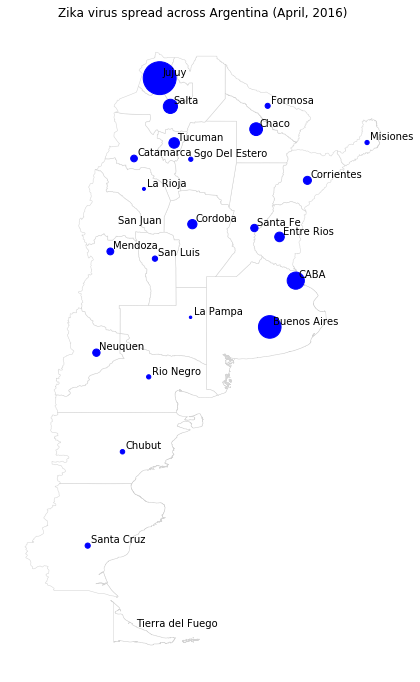

In [5]:
world = gpd.read_file("shapefiles/provinces/ARG_adm1.shp")
ax = world.plot(color = 'white', 
                linewidth = 0.5, 
                edgecolor = 'lightgrey', 
                figsize = (20, 12))

points = [Point(xy) for xy in zip(zika_data["longitude"], zika_data["latitude"])]
zika_df = gpd.GeoDataFrame(zika_data, crs = {'init': 'epsg:4326'}, geometry = points)

zika_df.plot(color = 'blue', ax = ax, markersize = 'value')
plt.title("Zika virus spread across Argentina (April, 2016)")
for lat, long, name in zip(zika_data["latitude"], 
                           zika_data["longitude"], 
                           zika_data["location"]):
    ax.annotate(name, xy=(long, lat), xytext=(3, 3), textcoords="offset points")
ax.axis('off')

## Choropleth map of Zika Virus

A better representation for Zika Virus spread would be a choropleth plot across its provinces.

In [6]:
map_df = gpd.read_file("shapefiles/provinces/ARG_adm1.shp")
map_df.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,HASC_1,CCN_1,CCA_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,12,ARG,Argentina,1,Buenos Aires,AR.BA,0,None,Provincia,Province,None,Baires|Buenos Ayres,"MULTIPOLYGON (((-62.79792 -41.02708, -62.79863..."
1,12,ARG,Argentina,2,Córdoba,AR.CB,0,None,Provincia,Province,None,Cordova,"POLYGON ((-63.91583 -29.61752, -63.89259 -29.6..."
2,12,ARG,Argentina,3,Catamarca,AR.CT,0,None,Provincia,Province,None,None,"POLYGON ((-67.56227 -25.26014, -67.55945 -25.2..."
3,12,ARG,Argentina,4,Chaco,AR.CC,0,None,Provincia,Province,None,El Chaco|Presidente Juan Peron,"POLYGON ((-62.32162 -24.10896, -62.32147 -24.1..."
4,12,ARG,Argentina,5,Chubut,AR.CH,0,None,Provincia,Province,None,None,"MULTIPOLYGON (((-66.99986 -46.00014, -67.00014..."


The data reveals that the name of the provinces do not match with the Zika virus data and thus, first need to rename the provinces before we merge the two datasets for a beautiful choropleth plot.

In [7]:
location_mapper = {"CABA": "Ciudad de Buenos Aires", 
                   "Cordoba": "Córdoba", 
                   "Entre Rios": "Entre Ríos", 
                   "Neuquen": "Neuquén", 
                   "Rio Negro": "Río Negro", 
                   "Sgo Del Estero": "Santiago del Estero", 
                   "Tucuman": "Tucumán"}

zika_data["location"] = zika_data["location"] \
                        .apply(lambda x: location_mapper[x] 
                               if (x) in location_mapper.keys() 
                               else x )

(-74.57707901000971,
 -52.592537689208925,
 -56.725680255889834,
 -20.114398097991888)

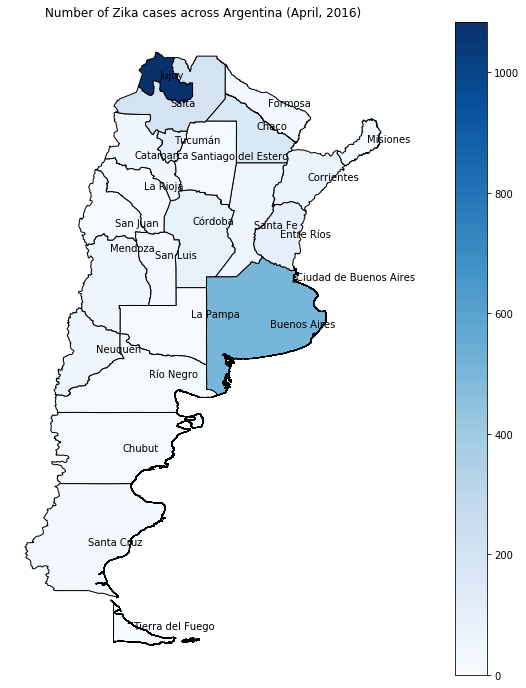

In [8]:
merged = map_df.merge(zika_data[["location", "value"]], left_on = "NAME_1", right_on = "location")

ax = merged.plot(column = 'value', cmap = "Blues", legend = True, figsize = (20, 12), edgecolor = 'black')
plt.title("Number of Zika cases across Argentina (April, 2016)")
for lat, long, name in zip(zika_data["latitude"], 
                           zika_data["longitude"], 
                           zika_data["location"]):
    ax.annotate(name, xy=(long, lat), xytext = (0, 0), textcoords="offset points", color = "black")
ax.axis("off")

From the plot above, we infer that Jujuy had the maximum number of Zika cases, followed by Buenos Aires in April, 2019.

## Precipitation spread

Let's plot the peripitation distribution across Argentina. Here, we'll be working with April, 2016 data.

(-74.57737693511623,
 -52.592523502299095,
 -56.743037316433366,
 -20.11357157129934)

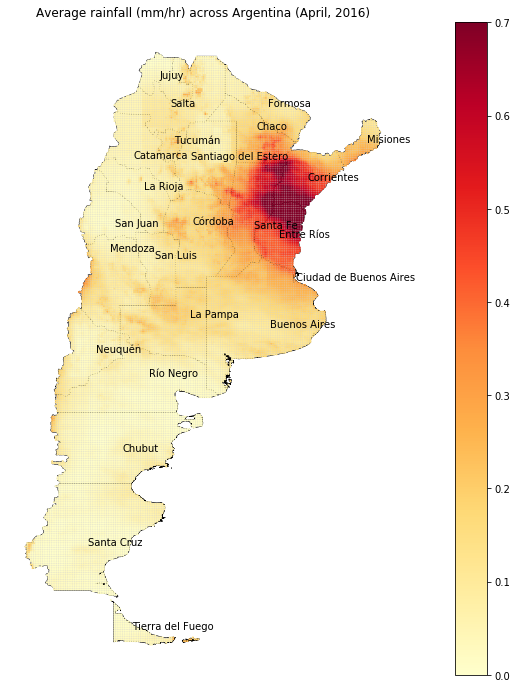

In [9]:
world = gpd.read_file("shapefiles/provinces/ARG_adm1.shp")
ax = world.plot(color = 'lightgrey', linewidth = 0.5, edgecolor = 'black', figsize = (20, 12))

points = [Point(xy) for xy in zip(precipitation_data["longitude"], precipitation_data["latitude"])]
geo_df = gpd.GeoDataFrame(precipitation_data, crs = {'init': 'epsg:4326'}, geometry = points)

geo_df.plot(column = 'precipitation', 
            markersize = 1, 
            ax = ax, 
            legend = True, 
            cmap = 'YlOrRd', 
            vmin = 0.0, 
            vmax = 0.7)
for lat, long, name in zip(zika_data["latitude"], 
                           zika_data["longitude"], 
                           zika_data["location"]):
    ax.annotate(name, xy=(long, lat), xytext = (0, 0), textcoords="offset points", color = "black")
    
plt.title("Average rainfall (mm/hr) across Argentina (April, 2016)")
ax.axis('off')

The plot above reveals that in April, 2016, `Entre Rios`, `Santa Fe` and `Corrientes` received the maximum rainfall.

#### Key observation
Considering the geo plots for Zika spread and rainfall, we observe that the province for maximum Zika cases (Jujuy) does not align with the province with maximum rainfall (Entre Rios) for April, 2016 indicating that a direct correlation between rainfall and Zika spread might not exist.